In [98]:
import spinmob as s
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.optimize as opt
import os
import mcphysics as m

user_path = '/Users/oliviapereira/Desktop' if (os.path.isdir('/Users/oliviapereira')) else '/Users/audrey/Documents/PHYS469'

# make plt plot inline
%matplotlib inline

1. conda install pip spyder pyqtgraph
2. pip install spinmob mcphysics imageio sounddevice

## Loading in the data

In [58]:
folder_path = user_path + '/PHYS469/alpha_decay/raw_data/'

am_data = m.data.load_chn(folder_path + 'am_source.chn')
pb_data = m.data.load_chn(folder_path + 'lead2_extended.chn')
calibration_data = m.data.load_chn(folder_path + 'calibration_1.chn')

channels = am_data.columns['Channel']
am_counts = am_data.columns['Counts']
pb_counts = pb_data.columns['Counts']  
pulser_counts = calibration_data.columns['Counts'] 

## Creating the energy scale

In [ ]:
# fit the calibration data
popt, pcov = opt.curve_fit(calibration_fit, pulser_channels, pulser_voltages, p0=[1, 0])
m, b = popt

# get the calibration function
calibration = interp1d(calibration_fit(channels, m, b), channels)

# fit a straight line to the calibration data
calibration_fit = np.poly1d(np.polyfit(pulser_channels, pulser_voltages, 1))

# convert the channels to voltages 
voltages = calibration_fit(channels)

# we know that energy and voltage scale linearly, and know the energy of am_peak bin
am_peak_energy = 5.486 # MeV
energy = am_peak_energy * voltages / voltages[am_peak]

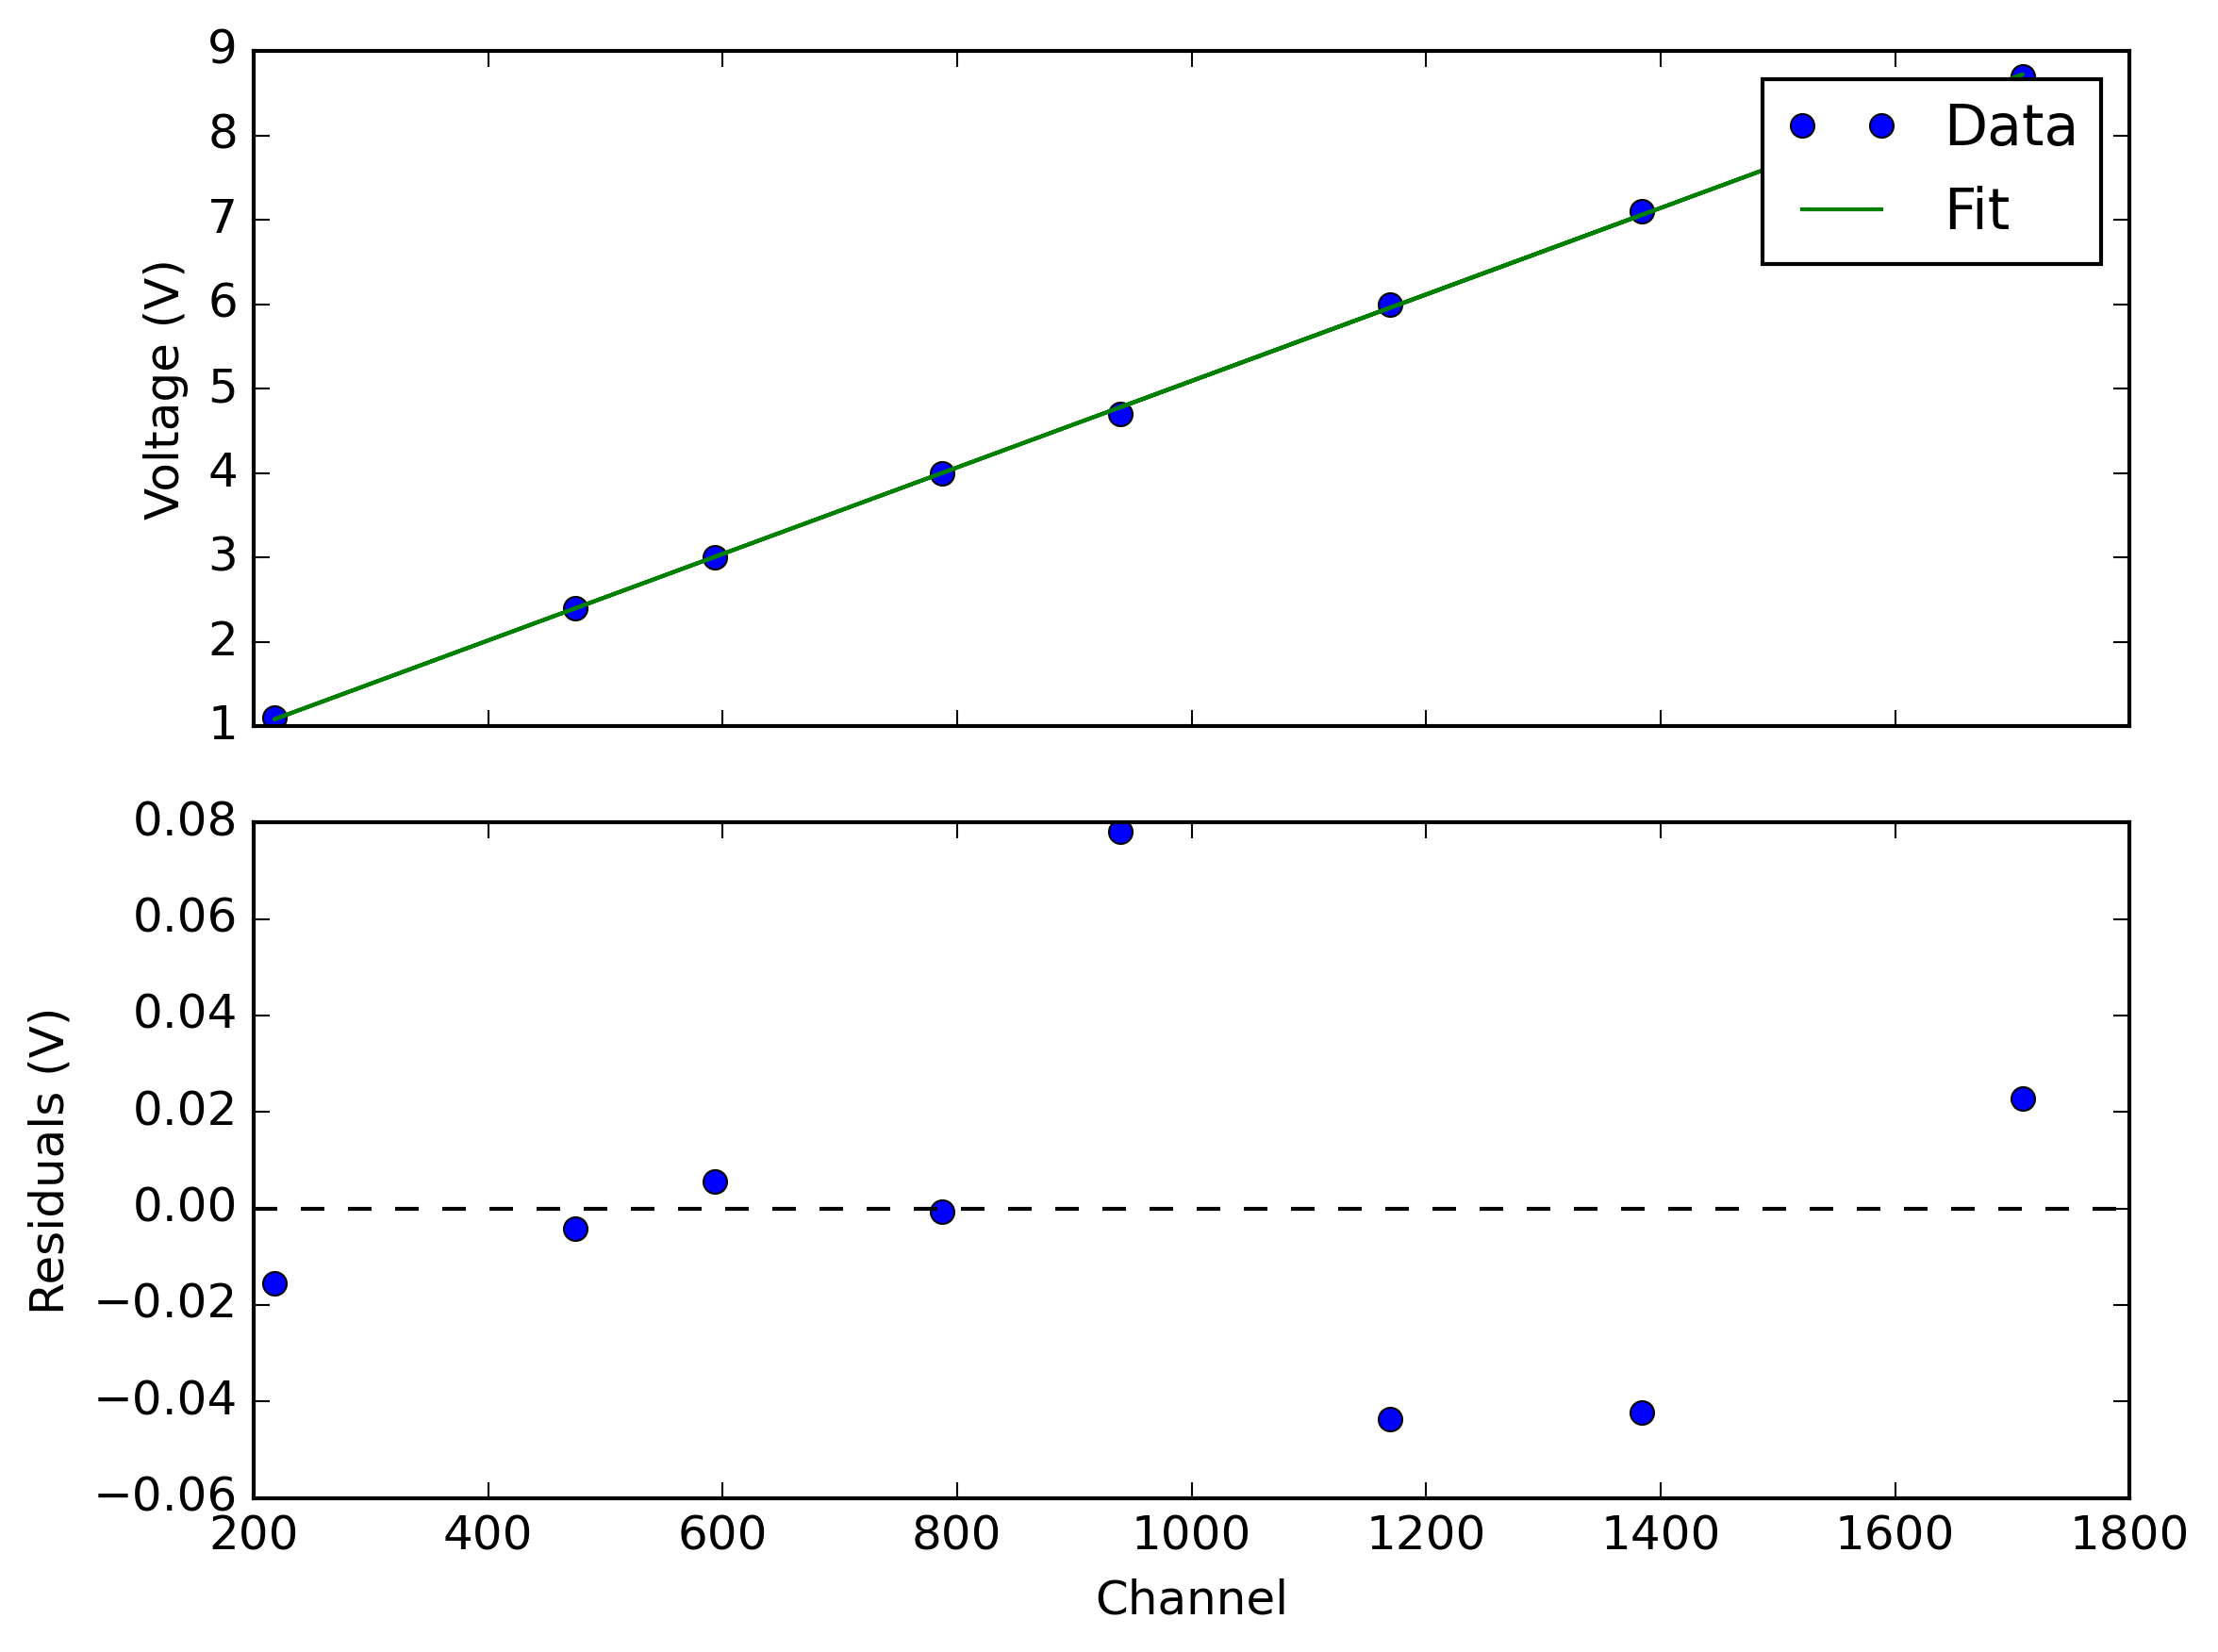

In [142]:
def calibration_fit(channels, m, b):
    return m * channels + b

# using the Americium to get a known point: 
am_peak = np.where(am_counts == np.max(am_counts))[0][0]

# voltage calibrations we took with the pulser
pulser_voltages = np.array([4.7, 8.7, 2.4, 1.1, 3, 4, 6, 7.1])
pulser_channels = np.array([939, 1709, 474, 218, 593, 787, 1169, 1384])

# fit the calibration data
popt, pcov = opt.curve_fit(calibration_fit, pulser_channels, pulser_voltages, p0=[1, 0])
m, b = popt


# plot the fit and residuals
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6), dpi = 300)

# Main plot
ax1.plot(pulser_channels, pulser_voltages, 'o', label='Data')
ax1.plot(pulser_channels, calibration_fit(pulser_channels, m, b), label='Fit')
ax1.set_ylabel('Voltage (V)')
ax1.legend(loc = 'upper right')

# Residuals plot
ax2.plot(pulser_channels, calibration_fit(pulser_channels, m, b) - pulser_voltages, 'o')
ax2.axhline(0, color='black', linestyle='--')
ax2.set_xlabel('Channel')
ax2.set_ylabel('Residuals (V)')

plt.tight_layout()
plt.show()



In [143]:
# get the calibration function
calibration = interp1d(calibration_fit(channels, m, b), channels)

# fit a straight line to the calibration data
calibration_fit = np.poly1d(np.polyfit(pulser_channels, pulser_voltages, 1))

# convert the channels to voltages
voltages = calibration_fit(channels)

# we know that energy and voltage scale linearly, and know the energy of am_peak bin
am_peak_energy = 5.486 # MeV
energy = am_peak_energy * voltages / voltages[am_peak]

## Identifying lead peaks

In [145]:
# finding the peaks in the lead spectrum. note: highest peak is from us leaving the pulser on

# getting local maxima in spectra
peaks = []
for i in range(1, len(pb_counts) - 1000):
    if pb_counts[i] > 500:
        if pb_counts[i] > pb_counts[i - 1] and pb_counts[i] > pb_counts[i + 1]:
            peaks.append(i)

print('The peaks are at channels:', peaks, 'corresponding to energies:', energy[peaks], 'MeV.')

# uncertainties?

The peaks are at channels: [521, 751] corresponding to energies: [6.08940835 8.81066169] MeV.


(0.0, 3000.0)

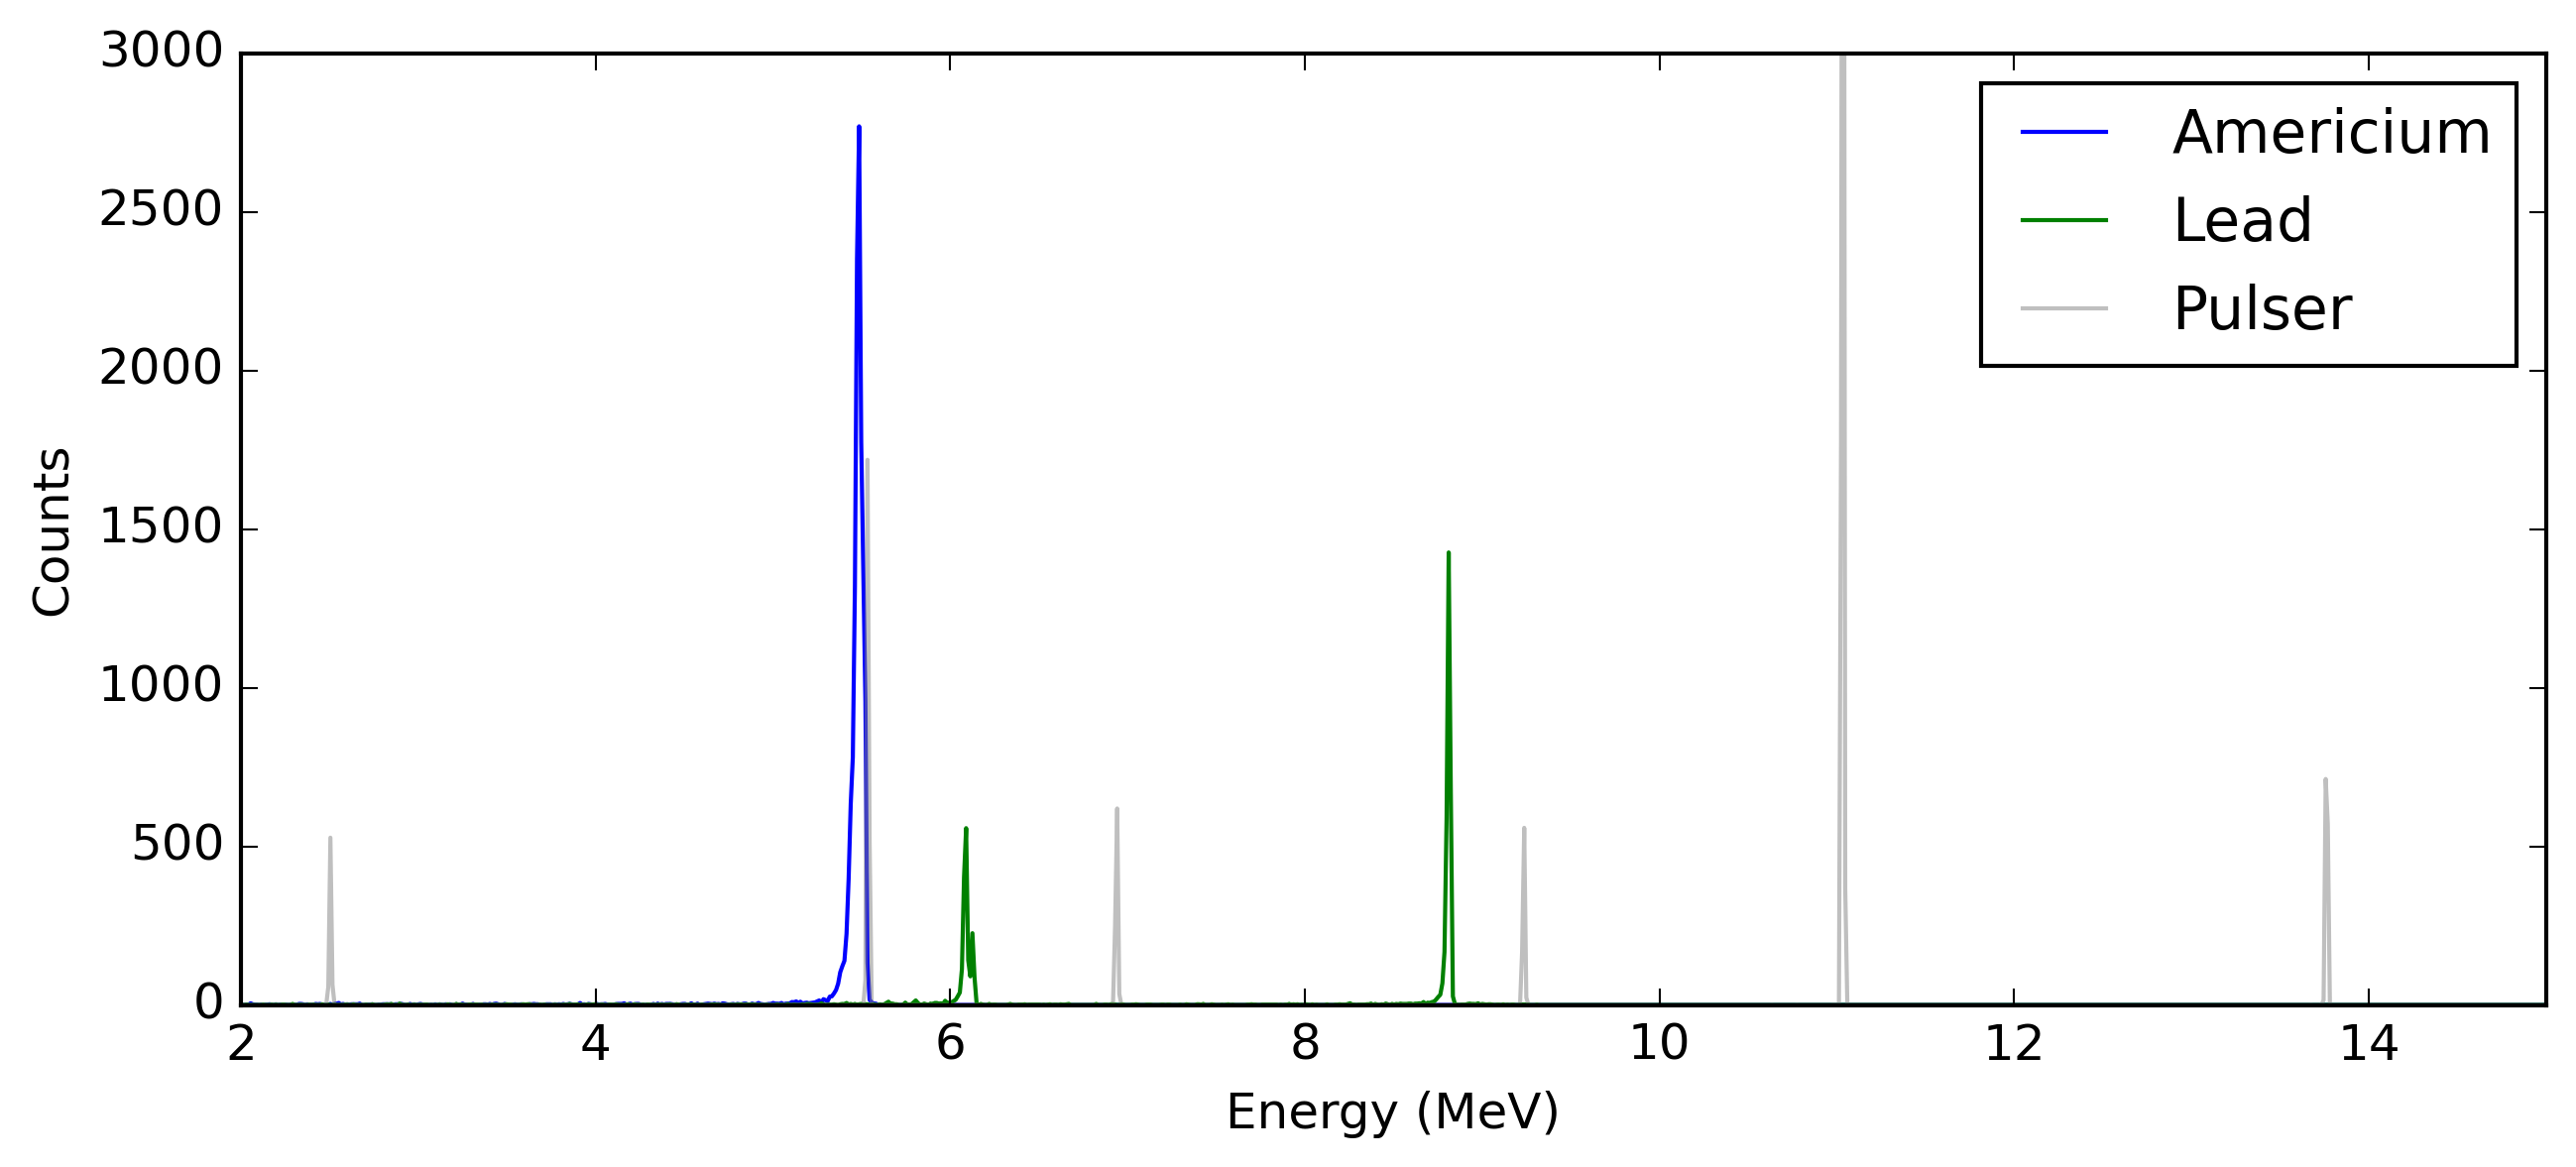

In [146]:
# plotting the spectra with our americium calibration data and the lead data 
plt.figure(figsize = (10, 4), dpi = 300)
plt.plot(energy, am_counts, label='Americium')
plt.plot(energy, pb_counts, label='Lead')
plt.plot(energy, pulser_counts, label='Pulser', color = 'grey', alpha = 0.5)
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.legend()
plt.xlim(2, 15)
plt.ylim(0, 3000)

Couple of things:
- we see an extra peak next to the smaller lead peak
- for the errors, i think we can take the spread of the peak above a certain count threshold and say its that, kind of like a standard deviation. We can take the standard devaition of points around the peak above a certain threshold to account for noise. This could also cause errors with our calibrations. 